# Homework6

In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict
from tqdm import tqdm

import torch
import torch.distributions as TD
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torchvision.utils import make_grid
# from fastai.basics import gzip

# USE_CUDA = torch.cuda.is_available()
if torch.cuda.is_available():
    DEVICE = 'cuda'
    GPU_DEVICE = 1
    torch.cuda.set_device(GPU_DEVICE)
else:
    DEVICE='cpu'

USE_CUDA=True
print('cuda is available:', USE_CUDA)

import warnings
warnings.filterwarnings('ignore')

# dgm_utils
import sys
sys.path.append('../../homeworks') # to grab dgm_utils from ../../homeworks directory
from dgm_utils import train_model, plot_training_curves
from dgm_utils import visualize_2d_data, visualize_2d_samples
from dgm_utils import show_samples, visualize_images, load_pickle

cuda is available: True


Cifar10 loading

In [2]:
!gdown --id 1FZcV8Mm91fiXm2jFnB0jvK5ROyHdJFvj

/usr/local/lib/python3.6/dist-packages/gdown/cli.py:125: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1FZcV8Mm91fiXm2jFnB0jvK5ROyHdJFvj
To: /home/pvmokrov/DGMIsachenko/2022-2023-DGM-AIMasters-course/seminars/seminar7/cifar10.pkl
100%|########################################| 185M/185M [00:02<00:00, 85.5MB/s]


Mnist loading

In [3]:
!gdown --id 1eTH_3i6yShm5yQikO0KdDEG3Hue9lNoZ

/usr/local/lib/python3.6/dist-packages/gdown/cli.py:125: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1eTH_3i6yShm5yQikO0KdDEG3Hue9lNoZ
To: /home/pvmokrov/DGMIsachenko/2022-2023-DGM-AIMasters-course/seminars/seminar7/mnist.pkl
100%|######################################| 55.4M/55.4M [00:01<00:00, 34.5MB/s]


In [3]:
def grayscale_dataset(data):
    '''
    data : ndarray (N, 3, w, h)
    '''
    assert isinstance(data, np.ndarray)
    assert data.shape[1] == 3
    return np.sum(data, axis=1, keepdims=True) / 3.

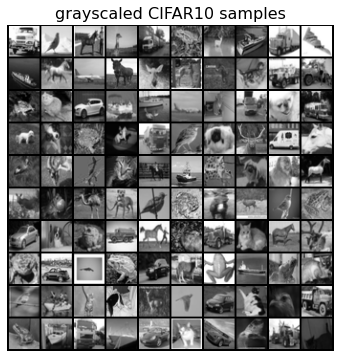

In [4]:
train_data_cifar, test_data_cifar = load_pickle('./cifar10.pkl', flatten=False, binarize=False)
train_data_cifar, test_data_cifar = grayscale_dataset(train_data_cifar), grayscale_dataset(test_data_cifar)
visualize_images(train_data_cifar, 'grayscaled CIFAR10 samples')

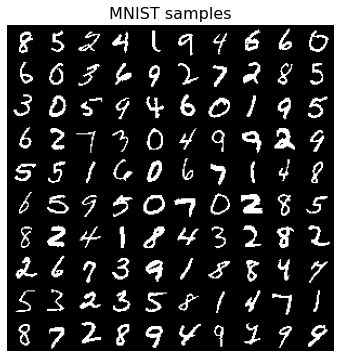

In [5]:
train_data_mnist, test_data_mnist = load_pickle('./mnist.pkl', flatten=False, binarize=True)
visualize_images(train_data_mnist, 'MNIST samples')

Here are the functions that we will you for training our model. Please, explore these functions carefully. You do not have to change them.

## Task 1: PixelCNN on MNIST and CIFAR10

[PixelCNN](https://arxiv.org/abs/1601.06759) model uses masked causal convoultions on images, we have discussed this model on lecture 2.

Here you have to train this model on MNIST images.

(see paper for details: https://arxiv.org/abs/1601.06759)

### Task 1.1: Train on MNIST

In [6]:
class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, in_channels, out_channels, kernel_size=5):
        assert mask_type in ['A', 'B']
        super().__init__(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=kernel_size // 2)
        self.register_buffer('mask', torch.zeros_like(self.weight))
        self.create_mask(mask_type)

    def forward(self, input):
        # ====
        # your code
        return F.conv2d(input, self.weight * self.mask, self.bias, padding=self.padding)
        # ====

    def create_mask(self, mask_type):
        # ====
        # your code
        # do not forget about mask_type
        k = self.kernel_size[0]
        self.mask[:, :, :k // 2] = 1
        self.mask[:, :, k // 2, :k // 2] = 1
        if mask_type == 'B':
            self.mask[:, :, k // 2, k // 2] = 1
        # ====

[Layer Normalization](https://arxiv.org/abs/1607.06450) helps to stabilize training process.

In [7]:
class LayerNorm(nn.LayerNorm):
    def __init__(self, n_filters):
        super().__init__(n_filters)

    def forward(self, x):
        x = x.permute(0, 2, 3, 1).contiguous()
        x = super().forward(x)
        return x.permute(0, 3, 1, 2).contiguous()

In [8]:
class PixelCNN(nn.Module):
    def __init__(
        self, 
        input_shape, 
        n_filters=64, 
        kernel_size=7, 
        n_categories=2,
        in_channels=1,
        n_layers=5, 
        use_layer_norm=True
    ):
      
        super().__init__()
        self.input_shape = input_shape
        self.n_categories = n_categories
        self.in_channels = in_channels

        # ====
        # your code
        # apply the sequence of MaskedConv2d -> LayerNorm (it is optional) -> ReLU
        # the last layer should be MaskedConv2d (not ReLU)
        # Note 1: the first conv layer should be of type 'A'
        # Note 2: final output_dim in MaskedConv2d must be 2
        model = [
            MaskedConv2d('A', in_channels, n_filters, kernel_size=kernel_size)
        ]
        for _ in range(n_layers):
            if use_layer_norm:
                model.append(LayerNorm(n_filters))
            model.append(nn.ReLU())
            model.append(
                MaskedConv2d('B', n_filters, n_filters, kernel_size=kernel_size)
            )

        model.extend([nn.ReLU(), MaskedConv2d(
            'B', in_channels=n_filters, out_channels=n_categories * in_channels, kernel_size=1)])

        self.net = nn.Sequential(*model)
        # ====

    def forward(self, x):
        # read the forward method carefully
        batch_size = x.shape[0]
        out = (x.float() - 0.5) / 0.5
        out = self.net(out)
        return out.view(batch_size, self.n_categories, self.in_channels, *self.input_shape)

    def loss(self, x):
        # ====
        # your code
        x_gt = torch.round(x * (self.n_categories - 1)).long()
        total_loss = F.cross_entropy(self(x), x_gt)
        # ====
        return {'total_loss': total_loss}

    def sample(self, n):
        # read carefully the sampling process
        samples = torch.zeros(n, 1, *self.input_shape).cuda()
        with torch.no_grad():
            for r in range(self.input_shape[0]):
                for c in range(self.input_shape[1]):
                    logits = self(samples)[:, :, :, r, c]
                    probs = F.softmax(logits, dim=1).squeeze(-1)
                    samples[:, 0, r, c] = torch.multinomial(probs, num_samples=1).squeeze(-1)
        return samples.cpu().numpy()

In [8]:
EPOCHS = 2 # > 5
BATCH_SIZE = 512  # any adequate value
LR = 1e-3 # < 1e-2
N_LAYERS = 5 # < 10
N_FILTERS = 64 # < 128
USE_LAYER_NORM = True
# ====

model = PixelCNN(
    input_shape=(28, 28), 
    n_filters=N_FILTERS, 
    kernel_size=5, 
    n_layers=N_LAYERS, 
    use_layer_norm=USE_LAYER_NORM
)

train_loader = data.DataLoader(train_data_mnist, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data_mnist, batch_size=BATCH_SIZE)
train_losses, test_losses = train_model(
    model, 
    train_loader, 
    test_loader, 
    epochs=EPOCHS, 
    lr=LR, 
    use_tqdm=True, 
    use_cuda=USE_CUDA
)

assert test_losses['total_loss'][-1] < 0.10

  0%|          | 0/2 [00:00<?, ?it/s]

AssertionError: 

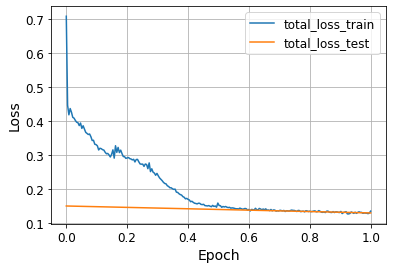

In [9]:
plot_training_curves(train_losses, test_losses)

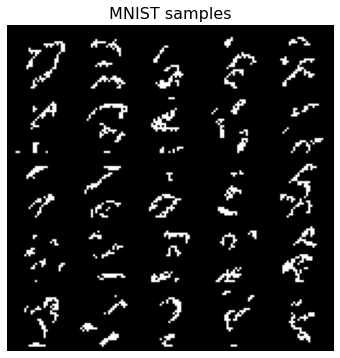

In [10]:
samples = model.sample(25)
show_samples(samples, title='MNIST samples', nrow=5)

In [ ]:
EPOCHS = 50 # > 5
BATCH_SIZE = 256 # any adequate value
LR = 1e-3 # < 1e-2
N_LAYERS = 5
N_FILTERS = 256
USE_LAYER_NORM = True
# ====

model = PixelCNN(
    input_shape=(32, 32), 
    n_filters=N_FILTERS, 
    kernel_size=5, 
    n_layers=N_LAYERS, 
    n_categories=256,
    use_layer_norm=USE_LAYER_NORM
)

train_loader = data.DataLoader(train_data_cifar, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data_cifar, batch_size=BATCH_SIZE)
# for n_ep in range(EPOCHS):
train_losses, test_losses = train_model(
    model, 
    train_loader, 
    test_loader, 
    epochs=EPOCHS, 
    lr=LR, 
    use_tqdm=True, 
    use_cuda=USE_CUDA
)
    # plt.plot(train_losses['total_loss'])
    # plt.plot(test_losses)
    # plot_training_curves(train_losses, test_losses)

# assert test_losses['total_loss'][-1] < 0.10

  0%|          | 0/50 [00:00<?, ?it/s]

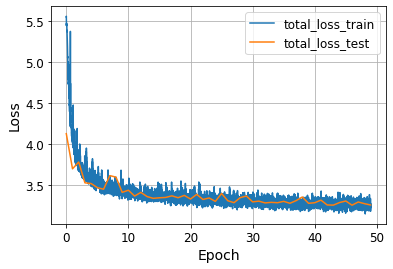

In [10]:
plot_training_curves(train_losses, test_losses)

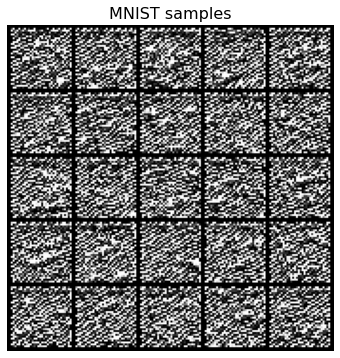

In [13]:
samples = model.sample(25) / 255.
show_samples(samples, title='MNIST samples', nrow=5)

## TODO: image autocomplete

## Task 3: PixelCNN++

[PixelCNN++](https://arxiv.org/pdf/1701.05517.pdf)

In [34]:
loc = torch.arange(32).view(2, 4, 4).float().permute(1, 2, 0)
scale = ((torch.arange(32).view(2, 4, 4).float() + 1.) / 10).permute(1, 2, 0)
pi = torch.softmax(torch.randn((2, 4, 4)), dim=0).permute(1, 2, 0)

In [39]:
def Logistic(loc, scale):
    return TD.TransformedDistribution(
        TD.Uniform(torch.zeros(loc.shape), torch.ones(loc.shape)),
        [TD.SigmoidTransform().inv, TD.AffineTransform(loc, scale)]
    )


In [47]:
def logistic_log_prob(logit, X):
    '''
    logit : tensor (bs, 3 * K, w, h), K is the number of logistic distributions in the mixture
    X : tensor (bs, 1, w, h), grayscaled image, pixel values are in the range [-1, 1]
    '''
    assert len(logit.shape) == len(X.shape) == 4
    assert logit.size(1) == (logit.size(1) // 3) * 3
    assert X.size(1) == 1
    
    # prepare distribution parameters from logits
    K = logit.size(1) // 3 # number of components in the mixture
    pis = torch.softmax(logit[:, :K, :, :], dim=1) # components of the categorical distribution
    mus = F.tanh(logit[:, K:2*K, :, :]) # limit mus to be in the range (-1, 1)
    scales = torch.exp(logit[:, 2*K:, :, :]) # scales are positive
    
    # make the mixture dimension to be the last tensor's dimension
    pis = pis.permute(0, 2, 3, 1) # (bs, w, h, K)
    mus = mus.permute(0, 2, 3, 1) # (bs, w, h, K)
    scales = scales.permute(0, 2, 3, 1) # (bs, w, h, K)
    
    # create the distribution
    dist = TD.MixtureSameFamily(
        TD.Categorical(probs=pis),
        Logistic(loc=mus, scale=scales)
    )
    
    # estimate the P(X | pis, mus, scales) = 
    # = F(X + 1/256 | pics, mus, scales) - F(X - 1/256 | pics, mus, scalse) if X < 1 - 1/256 and X > -1 + 1/256
    # = 1 - F(X - 1/256 | pics, mus, scales) if X >= 1 - 1/256
    # = F(X + 1/256 | pics, mus, scales), if X <= -1 + 1/256
    
    X = X.squeeze(1) # (bs, w, h)
    F_X_plus = dist.cdf(X + 1./256) # (bs, w, h)
    F_X_minus = dist.cdf(X - 1./256) # (bs, w, h)
    F_X_plus[X >= 1. - 3./512] = 1.
    F_X_minus[X <= -1. + 3./512] = 0
    prob = F_X_plus - F_X_minus
    return torch.log(prob)


In [ ]:
from torch.distributions import Uniform, SigmoidTransform, AffineTransform, TransformedDistribution, MixtureSameFamily

def Logistic(loc, scale):
    return TransformedDistribution(Uniform(0, 1), [SigmoidTransform().inv, AffineTransform(loc, scale)])

cat = t.rand(10, 1)
dist = MixtureSameFamily(
    Categorical(probs=t.cat([1-cat, cat], dim=1)),
    Logistic(loc=t.randn(10, 2), scale=t.ones(10, 2))
)

print(dist.sample())

In [ ]:
def log_sum_exp(x):
    """ numerically stable log_sum_exp implementation that prevents overflow """
    # TF ordering
    axis  = len(x.size()) - 1
    m, _  = torch.max(x, dim=axis)
    m2, _ = torch.max(x, dim=axis, keepdim=True)
    return m + torch.log(torch.sum(torch.exp(x - m2), dim=axis))


def log_prob_from_logits(x):
    """ numerically stable log_softmax implementation that prevents overflow """
    # TF ordering
    axis = len(x.size()) - 1
    m, _ = torch.max(x, dim=axis, keepdim=True)
    return x - m - torch.log(torch.sum(torch.exp(x - m), dim=axis, keepdim=True))


def discretized_mix_logistic_loss(x, l):
    """ log-likelihood for mixture of discretized logistics, assumes the data has been rescaled to [-1,1] interval """
    # Pytorch ordering
    x = x.permute(0, 2, 3, 1)
    l = l.permute(0, 2, 3, 1)
    xs = [int(y) for y in x.size()]
    ls = [int(y) for y in l.size()]
   
    # here and below: unpacking the params of the mixture of logistics
    nr_mix = int(ls[-1] / 10) 
    logit_probs = l[:, :, :, :nr_mix]
    l = l[:, :, :, nr_mix:].contiguous().view(xs + [nr_mix * 3]) # 3 for mean, scale, coef
    means = l[:, :, :, :, :nr_mix]
    # log_scales = torch.max(l[:, :, :, :, nr_mix:2 * nr_mix], -7.)
    log_scales = torch.clamp(l[:, :, :, :, nr_mix:2 * nr_mix], min=-7.)
   
    coeffs = F.tanh(l[:, :, :, :, 2 * nr_mix:3 * nr_mix])
    # here and below: getting the means and adjusting them based on preceding
    # sub-pixels
    x = x.contiguous()
    x = x.unsqueeze(-1) + Variable(torch.zeros(xs + [nr_mix]).cuda(), requires_grad=False)
    m2 = (means[:, :, :, 1, :] + coeffs[:, :, :, 0, :]
                * x[:, :, :, 0, :]).view(xs[0], xs[1], xs[2], 1, nr_mix)

    m3 = (means[:, :, :, 2, :] + coeffs[:, :, :, 1, :] * x[:, :, :, 0, :] +
                coeffs[:, :, :, 2, :] * x[:, :, :, 1, :]).view(xs[0], xs[1], xs[2], 1, nr_mix)

    means = torch.cat((means[:, :, :, 0, :].unsqueeze(3), m2, m3), dim=3)
    centered_x = x - means
    inv_stdv = torch.exp(-log_scales)
    plus_in = inv_stdv * (centered_x + 1. / 255.)
    cdf_plus = F.sigmoid(plus_in)
    min_in = inv_stdv * (centered_x - 1. / 255.)
    cdf_min = F.sigmoid(min_in)
    # log probability for edge case of 0 (before scaling)
    log_cdf_plus = plus_in - F.softplus(plus_in)
    # log probability for edge case of 255 (before scaling)
    log_one_minus_cdf_min = -F.softplus(min_in)
    cdf_delta = cdf_plus - cdf_min  # probability for all other cases
    mid_in = inv_stdv * centered_x
    # log probability in the center of the bin, to be used in extreme cases
    # (not actually used in our code)
    log_pdf_mid = mid_in - log_scales - 2. * F.softplus(mid_in)

    # now select the right output: left edge case, right edge case, normal
    # case, extremely low prob case (doesn't actually happen for us)

    # this is what we are really doing, but using the robust version below for extreme cases in other applications and to avoid NaN issue with tf.select()
    # log_probs = tf.select(x < -0.999, log_cdf_plus, tf.select(x > 0.999, log_one_minus_cdf_min, tf.log(cdf_delta)))

    # robust version, that still works if probabilities are below 1e-5 (which never happens in our code)
    # tensorflow backpropagates through tf.select() by multiplying with zero instead of selecting: this requires use to use some ugly tricks to avoid potential NaNs
    # the 1e-12 in tf.maximum(cdf_delta, 1e-12) is never actually used as output, it's purely there to get around the tf.select() gradient issue
    # if the probability on a sub-pixel is below 1e-5, we use an approximation
    # based on the assumption that the log-density is constant in the bin of
    # the observed sub-pixel value
    
    inner_inner_cond = (cdf_delta > 1e-5).float()
    inner_inner_out  = inner_inner_cond * torch.log(torch.clamp(cdf_delta, min=1e-12)) + (1. - inner_inner_cond) * (log_pdf_mid - np.log(127.5))
    inner_cond       = (x > 0.999).float()
    inner_out        = inner_cond * log_one_minus_cdf_min + (1. - inner_cond) * inner_inner_out
    cond             = (x < -0.999).float()
    log_probs        = cond * log_cdf_plus + (1. - cond) * inner_out
    log_probs        = torch.sum(log_probs, dim=3) + log_prob_from_logits(logit_probs)
    
    return -torch.sum(log_sum_exp(log_probs))


def discretized_mix_logistic_loss_1d(x, l):
    """ log-likelihood for mixture of discretized logistics, assumes the data has been rescaled to [-1,1] interval """
    # Pytorch ordering
    x = x.permute(0, 2, 3, 1)
    l = l.permute(0, 2, 3, 1)
    xs = [int(y) for y in x.size()]
    ls = [int(y) for y in l.size()]

    # here and below: unpacking the params of the mixture of logistics
    nr_mix = int(ls[-1] / 3)
    logit_probs = l[:, :, :, :nr_mix]
    l = l[:, :, :, nr_mix:].contiguous().view(xs + [nr_mix * 2]) # 2 for mean, scale
    means = l[:, :, :, :, :nr_mix]
    log_scales = torch.clamp(l[:, :, :, :, nr_mix:2 * nr_mix], min=-7.)
    # here and below: getting the means and adjusting them based on preceding
    # sub-pixels
    x = x.contiguous()
    x = x.unsqueeze(-1) + Variable(torch.zeros(xs + [nr_mix]).cuda(), requires_grad=False)

    # means = torch.cat((means[:, :, :, 0, :].unsqueeze(3), m2, m3), dim=3)
    centered_x = x - means
    inv_stdv = torch.exp(-log_scales)
    plus_in = inv_stdv * (centered_x + 1. / 255.)
    cdf_plus = F.sigmoid(plus_in)
    min_in = inv_stdv * (centered_x - 1. / 255.)
    cdf_min = F.sigmoid(min_in)
    # log probability for edge case of 0 (before scaling)
    log_cdf_plus = plus_in - F.softplus(plus_in)
    # log probability for edge case of 255 (before scaling)
    log_one_minus_cdf_min = -F.softplus(min_in)
    cdf_delta = cdf_plus - cdf_min  # probability for all other cases
    mid_in = inv_stdv * centered_x
    # log probability in the center of the bin, to be used in extreme cases
    # (not actually used in our code)
    log_pdf_mid = mid_in - log_scales - 2. * F.softplus(mid_in)
    
    inner_inner_cond = (cdf_delta > 1e-5).float()
    inner_inner_out  = inner_inner_cond * torch.log(torch.clamp(cdf_delta, min=1e-12)) + (1. - inner_inner_cond) * (log_pdf_mid - np.log(127.5))
    inner_cond       = (x > 0.999).float()
    inner_out        = inner_cond * log_one_minus_cdf_min + (1. - inner_cond) * inner_inner_out
    cond             = (x < -0.999).float()
    log_probs        = cond * log_cdf_plus + (1. - cond) * inner_out
    log_probs        = torch.sum(log_probs, dim=3) + log_prob_from_logits(logit_probs)
    
    return -torch.sum(log_sum_exp(log_probs))


def to_one_hot(tensor, n, fill_with=1.):
    # we perform one hot encore with respect to the last axis
    one_hot = torch.FloatTensor(tensor.size() + (n,)).zero_()
    if tensor.is_cuda : one_hot = one_hot.cuda()
    one_hot.scatter_(len(tensor.size()), tensor.unsqueeze(-1), fill_with)
    return Variable(one_hot)


def sample_from_discretized_mix_logistic_1d(l, nr_mix):
    # Pytorch ordering
    l = l.permute(0, 2, 3, 1)
    ls = [int(y) for y in l.size()]
    xs = ls[:-1] + [1] #[3]

    # unpack parameters
    logit_probs = l[:, :, :, :nr_mix]
    l = l[:, :, :, nr_mix:].contiguous().view(xs + [nr_mix * 2]) # for mean, scale

    # sample mixture indicator from softmax
    temp = torch.FloatTensor(logit_probs.size())
    if l.is_cuda : temp = temp.cuda()
    temp.uniform_(1e-5, 1. - 1e-5)
    temp = logit_probs.data - torch.log(- torch.log(temp))
    _, argmax = temp.max(dim=3)
   
    one_hot = to_one_hot(argmax, nr_mix)
    sel = one_hot.view(xs[:-1] + [1, nr_mix])
    # select logistic parameters
    means = torch.sum(l[:, :, :, :, :nr_mix] * sel, dim=4) 
    log_scales = torch.clamp(torch.sum(
        l[:, :, :, :, nr_mix:2 * nr_mix] * sel, dim=4), min=-7.)
    u = torch.FloatTensor(means.size())
    if l.is_cuda : u = u.cuda()
    u.uniform_(1e-5, 1. - 1e-5)
    u = Variable(u)
    x = means + torch.exp(log_scales) * (torch.log(u) - torch.log(1. - u))
    x0 = torch.clamp(torch.clamp(x[:, :, :, 0], min=-1.), max=1.)
    out = x0.unsqueeze(1)
    return out


def sample_from_discretized_mix_logistic(l, nr_mix):
    # Pytorch ordering
    l = l.permute(0, 2, 3, 1)
    ls = [int(y) for y in l.size()]
    xs = ls[:-1] + [3]

    # unpack parameters
    logit_probs = l[:, :, :, :nr_mix]
    l = l[:, :, :, nr_mix:].contiguous().view(xs + [nr_mix * 3])
    # sample mixture indicator from softmax
    temp = torch.FloatTensor(logit_probs.size())
    if l.is_cuda : temp = temp.cuda()
    temp.uniform_(1e-5, 1. - 1e-5)
    temp = logit_probs.data - torch.log(- torch.log(temp))
    _, argmax = temp.max(dim=3)
   
    one_hot = to_one_hot(argmax, nr_mix)
    sel = one_hot.view(xs[:-1] + [1, nr_mix])
    # select logistic parameters
    means = torch.sum(l[:, :, :, :, :nr_mix] * sel, dim=4) 
    log_scales = torch.clamp(torch.sum(
        l[:, :, :, :, nr_mix:2 * nr_mix] * sel, dim=4), min=-7.)
    coeffs = torch.sum(F.tanh(
        l[:, :, :, :, 2 * nr_mix:3 * nr_mix]) * sel, dim=4)
    # sample from logistic & clip to interval
    # we don't actually round to the nearest 8bit value when sampling
    u = torch.FloatTensor(means.size())
    if l.is_cuda : u = u.cuda()
    u.uniform_(1e-5, 1. - 1e-5)
    u = Variable(u)
    x = means + torch.exp(log_scales) * (torch.log(u) - torch.log(1. - u))
    x0 = torch.clamp(torch.clamp(x[:, :, :, 0], min=-1.), max=1.)
    x1 = torch.clamp(torch.clamp(
       x[:, :, :, 1] + coeffs[:, :, :, 0] * x0, min=-1.), max=1.)
    x2 = torch.clamp(torch.clamp(
       x[:, :, :, 2] + coeffs[:, :, :, 1] * x0 + coeffs[:, :, :, 2] * x1, min=-1.), max=1.)

    out = torch.cat([x0.view(xs[:-1] + [1]), x1.view(xs[:-1] + [1]), x2.view(xs[:-1] + [1])], dim=3)
    # put back in Pytorch ordering
    out = out.permute(0, 3, 1, 2)
    return out



''' utilities for shifting the image around, efficient alternative to masking convolutions '''
def down_shift(x, pad=None):
    # Pytorch ordering
    xs = [int(y) for y in x.size()]
    # when downshifting, the last row is removed 
    x = x[:, :, :xs[2] - 1, :]
    # padding left, padding right, padding top, padding bottom
    pad = nn.ZeroPad2d((0, 0, 1, 0)) if pad is None else pad
    return pad(x)


def right_shift(x, pad=None):
    # Pytorch ordering
    xs = [int(y) for y in x.size()]
    # when righshifting, the last column is removed 
    x = x[:, :, :, :xs[3] - 1]
    # padding left, padding right, padding top, padding bottom
    pad = nn.ZeroPad2d((1, 0, 0, 0)) if pad is None else pad
    return pad(x)


def load_part_of_model(model, path):
    params = torch.load(path)
    added = 0
    for name, param in params.items():
        if name in model.state_dict().keys():
            try : 
                model.state_dict()[name].copy_(param)
                added += 1
            except Exception as e:
                print e
                pass
    print('added %s of params:' % (added / float(len(model.state_dict().keys()))))

In [ ]:
def discretized_mix_logistic_loss(x, l):
    """ log-likelihood for mixture of discretized logistics, assumes the data has been rescaled to [-1,1] interval """
    # Pytorch ordering
    x = x.permute(0, 2, 3, 1)
    l = l.permute(0, 2, 3, 1)
    xs = [int(y) for y in x.size()]
    ls = [int(y) for y in l.size()]
   
    # here and below: unpacking the params of the mixture of logistics
    nr_mix = int(ls[-1] / 10)
    logit_probs = l[:, :, :, :nr_mix]
    l = l[:, :, :, nr_mix:].contiguous().view(xs + [nr_mix * 3]) # 3 for mean, scale, coef
    means = l[:, :, :, :, :nr_mix]
    # log_scales = torch.max(l[:, :, :, :, nr_mix:2 * nr_mix], -7.)
    log_scales = torch.clamp(l[:, :, :, :, nr_mix:2 * nr_mix], min=-7.)
   
    coeffs = F.tanh(l[:, :, :, :, 2 * nr_mix:3 * nr_mix])
    # here and below: getting the means and adjusting them based on preceding
    # sub-pixels
    x = x.contiguous()
    x = x.unsqueeze(-1) + Variable(torch.zeros(xs + [nr_mix]).cuda(), requires_grad=False)
    m2 = (means[:, :, :, 1, :] + coeffs[:, :, :, 0, :]
                * x[:, :, :, 0, :]).view(xs[0], xs[1], xs[2], 1, nr_mix)

    m3 = (means[:, :, :, 2, :] + coeffs[:, :, :, 1, :] * x[:, :, :, 0, :] +
                coeffs[:, :, :, 2, :] * x[:, :, :, 1, :]).view(xs[0], xs[1], xs[2], 1, nr_mix)

    means = torch.cat((means[:, :, :, 0, :].unsqueeze(3), m2, m3), dim=3)
    centered_x = x - means
    inv_stdv = torch.exp(-log_scales)
    plus_in = inv_stdv * (centered_x + 1. / 255.)
    cdf_plus = F.sigmoid(plus_in)
    min_in = inv_stdv * (centered_x - 1. / 255.)
    cdf_min = F.sigmoid(min_in)
    # log probability for edge case of 0 (before scaling)
    log_cdf_plus = plus_in - F.softplus(plus_in)
    # log probability for edge case of 255 (before scaling)
    log_one_minus_cdf_min = -F.softplus(min_in)
    cdf_delta = cdf_plus - cdf_min  # probability for all other cases
    mid_in = inv_stdv * centered_x
    # log probability in the center of the bin, to be used in extreme cases
    # (not actually used in our code)
    log_pdf_mid = mid_in - log_scales - 2. * F.softplus(mid_in)

    # now select the right output: left edge case, right edge case, normal
    # case, extremely low prob case (doesn't actually happen for us)

    # this is what we are really doing, but using the robust version below for extreme cases in other applications and to avoid NaN issue with tf.select()
    # log_probs = tf.select(x < -0.999, log_cdf_plus, tf.select(x > 0.999, log_one_minus_cdf_min, tf.log(cdf_delta)))

    # robust version, that still works if probabilities are below 1e-5 (which never happens in our code)
    # tensorflow backpropagates through tf.select() by multiplying with zero instead of selecting: this requires use to use some ugly tricks to avoid potential NaNs
    # the 1e-12 in tf.maximum(cdf_delta, 1e-12) is never actually used as output, it's purely there to get around the tf.select() gradient issue
    # if the probability on a sub-pixel is below 1e-5, we use an approximation
    # based on the assumption that the log-density is constant in the bin of
    # the observed sub-pixel value
    
    inner_inner_cond = (cdf_delta > 1e-5).float()
    inner_inner_out  = inner_inner_cond * torch.log(torch.clamp(cdf_delta, min=1e-12)) + (1. - inner_inner_cond) * (log_pdf_mid - np.log(127.5))
    inner_cond       = (x > 0.999).float()
    inner_out        = inner_cond * log_one_minus_cdf_min + (1. - inner_cond) * inner_inner_out
    cond             = (x < -0.999).float()
    log_probs        = cond * log_cdf_plus + (1. - cond) * inner_out
    log_probs        = torch.sum(log_probs, dim=3) + log_prob_from_logits(logit_probs)
    
    return -torch.sum(log_sum_exp(log_probs))

def discretized_mix_logistic_loss(x, l):
    """ log-likelihood for mixture of discretized logistics, assumes the data has been rescaled to [-1,1] interval """
    # Pytorch ordering
    x = x.permute(0, 2, 3, 1)
    l = l.permute(0, 2, 3, 1)
    xs = [int(y) for y in x.size()]
    ls = [int(y) for y in l.size()]
   
    # here and below: unpacking the params of the mixture of logistics
    nr_mix = int(ls[-1] / 10) 
    logit_probs = l[:, :, :, :nr_mix]
    l = l[:, :, :, nr_mix:].contiguous().view(xs + [nr_mix * 3]) # 3 for mean, scale, coef
    means = l[:, :, :, :, :nr_mix]
    # log_scales = torch.max(l[:, :, :, :, nr_mix:2 * nr_mix], -7.)
    log_scales = torch.clamp(l[:, :, :, :, nr_mix:2 * nr_mix], min=-7.)
   
    coeffs = F.tanh(l[:, :, :, :, 2 * nr_mix:3 * nr_mix])
    # here and below: getting the means and adjusting them based on preceding
    # sub-pixels
    x = x.contiguous()
    x = x.unsqueeze(-1) + Variable(torch.zeros(xs + [nr_mix]).cuda(), requires_grad=False)
    m2 = (means[:, :, :, 1, :] + coeffs[:, :, :, 0, :]
                * x[:, :, :, 0, :]).view(xs[0], xs[1], xs[2], 1, nr_mix)

    m3 = (means[:, :, :, 2, :] + coeffs[:, :, :, 1, :] * x[:, :, :, 0, :] +
                coeffs[:, :, :, 2, :] * x[:, :, :, 1, :]).view(xs[0], xs[1], xs[2], 1, nr_mix)

    means = torch.cat((means[:, :, :, 0, :].unsqueeze(3), m2, m3), dim=3)
    centered_x = x - means
    inv_stdv = torch.exp(-log_scales)
    plus_in = inv_stdv * (centered_x + 1. / 255.)
    cdf_plus = F.sigmoid(plus_in)
    min_in = inv_stdv * (centered_x - 1. / 255.)
    cdf_min = F.sigmoid(min_in)
    # log probability for edge case of 0 (before scaling)
    log_cdf_plus = plus_in - F.softplus(plus_in)
    # log probability for edge case of 255 (before scaling)
    log_one_minus_cdf_min = -F.softplus(min_in)
    cdf_delta = cdf_plus - cdf_min  # probability for all other cases
    mid_in = inv_stdv * centered_x
    # log probability in the center of the bin, to be used in extreme cases
    # (not actually used in our code)
    log_pdf_mid = mid_in - log_scales - 2. * F.softplus(mid_in)

    # now select the right output: left edge case, right edge case, normal
    # case, extremely low prob case (doesn't actually happen for us)

    # this is what we are really doing, but using the robust version below for extreme cases in other applications and to avoid NaN issue with tf.select()
    # log_probs = tf.select(x < -0.999, log_cdf_plus, tf.select(x > 0.999, log_one_minus_cdf_min, tf.log(cdf_delta)))

    # robust version, that still works if probabilities are below 1e-5 (which never happens in our code)
    # tensorflow backpropagates through tf.select() by multiplying with zero instead of selecting: this requires use to use some ugly tricks to avoid potential NaNs
    # the 1e-12 in tf.maximum(cdf_delta, 1e-12) is never actually used as output, it's purely there to get around the tf.select() gradient issue
    # if the probability on a sub-pixel is below 1e-5, we use an approximation
    # based on the assumption that the log-density is constant in the bin of
    # the observed sub-pixel value
    
    inner_inner_cond = (cdf_delta > 1e-5).float()
    inner_inner_out  = inner_inner_cond * torch.log(torch.clamp(cdf_delta, min=1e-12)) + (1. - inner_inner_cond) * (log_pdf_mid - np.log(127.5))
    inner_cond       = (x > 0.999).float()
    inner_out        = inner_cond * log_one_minus_cdf_min + (1. - inner_cond) * inner_inner_out
    cond             = (x < -0.999).float()
    log_probs        = cond * log_cdf_plus + (1. - cond) * inner_out
    log_probs        = torch.sum(log_probs, dim=3) + log_prob_from_logits(logit_probs)
    
    return -torch.sum(log_sum_exp(log_probs))

In [158]:
class PixelCNNpp(nn.Module):
    def __init__(
        self, 
        input_shape, 
        n_filters=64, 
        kernel_size=7, 
        in_chanels=1,
        n_layers=5, 
        use_layer_norm=True,
    ):
      
        super().__init__()
        self.input_shape = input_shape
        self.in_chanels = in_chanels

        # ====
        # your code
        # apply the sequence of MaskedConv2d -> LayerNorm -> ReLU
        # note that the first conv layer should be of type 'A' 
        # the last layer should be MaskedConv2d
        if use_layer_norm:
            layers = [MaskedConv2d('A', in_chanels, n_filters, kernel_size), LayerNorm(n_filters),  nn.ReLU()]
        else:
            layers = [MaskedConv2d('A', in_chanels, n_filters),  nn.ReLU()]
        for _ in range(n_layers-2):
            layers.append(MaskedConv2d('B', n_filters, n_filters, kernel_size))
            if use_layer_norm : layers.append(LayerNorm(n_filters))
            layers.append(nn.ReLU())
        layers.append(MaskedConv2d('B', n_filters, in_chanels, kernel_size))

        self.net = nn.Sequential(*layers)
        # ====

    def forward(self, x):
        batch_size = x.shape[0]
        out = self.net(x)
        return out.view(batch_size, self.in_chanels, *self.input_shape)

    def loss(self, x):
        # ====
        # your code
        return dict(total_loss = discretized_mix_logistic_loss(x, self(x)))
        # ====

    # def sample(self, n):
    #     # read carefully the sampling process
    #     samples = torch.zeros(n, self.in_chanels, *self.input_shape).cuda()
    #     with torch.no_grad():
    #         for r in range(self.input_shape[0]):
    #             for c in range(self.input_shape[1]):
    #                 logits = self(samples)[:, :, :, r, c]
    #                 probs = F.softmax(logits, dim=1)
    #                 for i in range(probs.size(2)):
    #                     samples[:, i, r, c] = torch.multinomial(probs[..., i], num_samples=1).squeeze(-1)
    #     return samples.permute(0, 2, 3, 1).cpu().numpy()

    # def autocomplete_image(self, img, n, autocomplete_lower=10):
    #     img_init = img.clone()
    #     img_init[:,autocomplete_lower:,:] = -1
    #     samples = img_init.unsqueeze(dim=0).expand(n,-1,-1,-1).cuda()

    #     with torch.no_grad():
    #         for r in range(autocomplete_lower, self.input_shape[0]):
    #             for c in range(self.input_shape[1]):
    #                 logits = self(samples)[:, :, :, r, c]
    #                 probs = F.softmax(logits, dim=1)
    #                 for i in range(probs.size(2)):
    #                     samples[:, i, r, c] = torch.multinomial(probs[..., i], num_samples=1).squeeze(-1)
    #     return samples.permute(0, 2, 3, 1).cpu().numpy()

In [159]:
# ====
# your code
EPOCHS = 5
BATCH_SIZE = 100
LR = 0.001
N_LAYERS = 5
N_FILTERS = 128
# ====

model = PixelCNNpp(
    input_shape=(32, 32), 
    n_filters=N_FILTERS, 
    kernel_size=5, 
    in_chanels=3,
    n_layers=N_LAYERS, 
    use_layer_norm=True,
)

loss = model.loss(torch.zeros(1, 3, 32, 32))
assert isinstance(loss, dict)
assert 'total_loss' in loss

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE)
train_losses, test_losses = train_model(model, train_loader, test_loader, epochs=EPOCHS, lr=LR, use_tqdm=True, use_cuda=USE_CUDA)

# assert test_losses['total_loss'][-1] < 0.11

RuntimeError: ignored

In [162]:
l = torch.zeros(1, 3, 32, 32)
x = model(l)

In [163]:
x = x.permute(0, 2, 3, 1)
l = l.permute(0, 2, 3, 1)
xs = [int(y) for y in x.size()]
ls = [int(y) for y in l.size()]

# here and below: unpacking the params of the mixture of logistics
nr_mix = int(ls[-1] / 10)
logit_probs = l[:, :, :, :nr_mix]
l = l[:, :, :, nr_mix:].contiguous().view(xs + [nr_mix * 3]) # 3 for mean, scale, coef
means = l[:, :, :, :, :nr_mix]

RuntimeError: ignored

In [ ]:
a = model(torch.zeros(1, 3, 32, 32))

In [ ]:
a.shape

torch.Size([1, 2, 3, 32, 32])